In [1]:
from montecarlo import *
from portfolio import *
import math

# montecarlo e ef
PERIODS = 252
#dur = 20
riskFreeRate = 0.01
numPortfolios = 1000

# randomwalk
NUM_YEARS = 10
NUM_MC_RUNS = 1000


%load_ext autoreload
%autoreload 2
%matplotlib inline

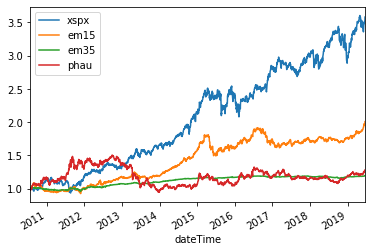

In [2]:
# data = pd.read_csv('quotes_clean_mach1.csv')  # daily quotes assets_all
#data = pd.read_csv('quote_mach2.csv')  # daily quotes assets_all
#data['dateTime'] = pd.to_datetime(data['dateTime'])
#data.set_index('dateTime', inplace=True)
assets_all = ['imeu','ceu','smea','iusa','csspx','phau','ibtm','ibgm', 'emg', 'em15', 'ibgl']
assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau'] # **
assets = ['imeu','cspxj','ieem','inaa','xmjp','xgle','phau']
assets = ['iusa','imeu','ibtm','xgle','phau']
assets = ['imeu','cspxj','ieem','inaa','xmjp','xgle','phau']
assets = ['xgle', 'ibtm', 'iusa', 'smea', 'ieem']
assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau']
assets = ['xesc','xspx','phau','em15','csbgu7']
assets = ['xspx','em15']
assets = ['xspx','em15','em35','phau']
assets_all = ['xesc','xspx','phau','csbgu7','csbgu3','ibtm','em13','em35','em57','em710','em1015','em15']

data = read_quotes(assets)

# correzione SMEA
if 'smea' in assets:
    x1 = data.smea.idxmin()
    data.smea.loc[x1] = data.smea.loc[x1 - pd.Timedelta(days=1)]

norm_data = data/data.iloc[0]
norm_data.plot()
# data.head()

## Montecarlo e Efficient Frontier

In [18]:
## MONTECARLO e Efficient Frontier
## portafoglio maxSharpe e minVar

results, meanDailyReturns, covMatrix = do_mc_simulation(data, assets, numPortfolios, PERIODS, riskFreeRate)

# Find efficient frontier
targetReturns = np.linspace(0.02, 0.12, 20)
efficientPortfolios = findEfficientFrontier(meanDailyReturns, 
                                            covMatrix, targetReturns, PERIODS)

# Find portfolio with maximum Sharpe ratio
maxSharpe = findMaxSharpeRatioPortfolio(meanDailyReturns, covMatrix,
                                        riskFreeRate, PERIODS)
retms, sdms = calcPortfolioPerf(maxSharpe['x'], meanDailyReturns, covMatrix, PERIODS)

# Find portfolio with minimum variance
minVar = findMinVariancePortfolio(meanDailyReturns, covMatrix, PERIODS)
retmv, sdmv = calcPortfolioPerf(minVar['x'], meanDailyReturns, covMatrix, PERIODS) 
    

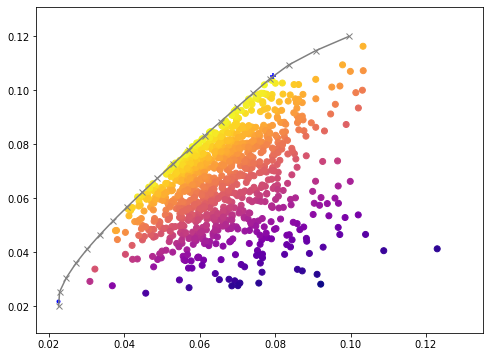

In [19]:
### PLOTTING

dfResults = results.copy()
dfResults = dfResults[['ret','vola','sharpe']]

fig10 = plt.figure(figsize = (8,6))
plt.scatter(dfResults.vola, dfResults.ret, c = dfResults.sharpe, marker = 'o', cmap='plasma')
plt.scatter(sdms, retms, c='blue', marker='+')
plt.scatter(sdmv, retmv, c='blue', marker='.')
plt.plot([p['fun'] for p in efficientPortfolios], targetReturns, marker='x', c='gray')

plt.show()



In [20]:
# Informazioni sul ptfolio migliore
# maxSharpe _fra_ i portafogli generati random

results.sharpe = pd.to_numeric(results.sharpe)

temp = results.iloc[results.sharpe.idxmax()]
results.iloc[results.sharpe.idxmax()]


ret        0.102037
vola      0.0771518
sharpe      1.19294
xspx       0.430911
em15       0.503704
em35      0.0376329
phau       0.027752
Name: 799, dtype: object

In [21]:
allocation = temp.iloc[3:]

## Plot portfolio rets

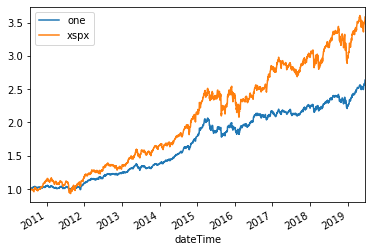

In [22]:
norm_df201 = norm_data.copy()

norm_df201['one'] = norm_data.mul(allocation.values,axis=1).sum(axis=1)

norm_df201.one.plot()
norm_df201.xspx.plot()  # per confronto, plotto il sp500
plt.legend()


In [25]:
returns = norm_data.pct_change()
returns.dropna(inplace=True)
exp_ret_one = np.sum(returns.mean()* allocation)* PERIODS
exp_std_one = np.sqrt(np.dot(allocation.T,np.dot(returns.cov()*PERIODS, allocation)))
sharpe_one = exp_ret_one/exp_std_one
print('Key Stats: Portfolio one')
print(82*'=')
print('Annualized Returns: {:.3%}'.format(exp_ret_one))
print('Annualized Volatility: {:.3%}'.format(exp_std_one))
print('Sharpe Ratio: {:.4}'.format(sharpe_one))
print(82*'-')

Key Stats: Portfolio one
Annualized Returns: 10.917%
Annualized Volatility: 7.706%
Sharpe Ratio: 1.417
----------------------------------------------------------------------------------


## Montecarlo su tutte le combinazioni di portafogli

In [ ]:
# combinazioni degli asset a gruppi

from itertools import combinations 
  
def combine(arr, s): 
    return list(combinations(arr, s)) 

ASSET_SUBSET = 3  # numero di etf che compongono il sottoinsieme di titoli del portafoglio da simulare 
                  # (deve essere minore di asset_all)
all_portfolio_combinations = combine(assets_all, ASSET_SUBSET)

all_results = pd.DataFrame(columns=['ret','vola','sharpe']+assets_all)

for num, asset_list in enumerate(all_portfolio_combinations):
    assets = list(asset_list)
    d = read_quotes(assets)
    # correzione SMEA
    if 'smea' in assets:
        x1 = d.smea.idxmin()
        d.smea.loc[x1] = d.smea.loc[x1 - pd.Timedelta(days=1)]
    
    results, meanDailyReturns, covMatrix = do_mc_simulation(d, assets, numPortfolios, PERIODS, riskFreeRate)

    results.sharpe = pd.to_numeric(results.sharpe)
    res = results.iloc[results.sharpe.idxmax()]
    
    print(asset_list, "{0:4.3f} {1:4.3f} {2:4.3f}".format(res.ret, res.vola, res.sharpe))
    #print(res)
    all_results = all_results.append(res)

In [58]:
all_results.to_csv('portfolio_combinations_mc_results_'+ str(ASSET_SUBSET) + '.csv')

In [32]:
all_results.reset_index(drop=True, inplace=True)
all_results.sharpe = pd.to_numeric(all_results.sharpe)
all_results.iloc[all_results.sharpe.idxmax()]

ret       0.080448
vola      0.055594
sharpe    1.267185
xesc           NaN
xspx      0.275676
phau           NaN
csbgu7         NaN
csbgu3         NaN
ibtm           NaN
em13           NaN
em35           NaN
em57           NaN
em710     0.441193
em1015    0.094987
em15      0.188143
Name: 284, dtype: float64

## Random Walk

In [6]:
# da runnare solo una volta, altrimenti rovina norm_data
pndata = norm_data.copy()

weights = minVar['x']
pndata['minvar'] = norm_data.mul(weights,axis=1).sum(axis=1)

weights = maxSharpe['x']
pndata['maxSharpe'] = norm_data.mul(weights,axis=1).sum(axis=1)

# pndata.head()

In [7]:
pct_ret = pndata.pct_change()
pct_ret.dropna(inplace=True)
#pct_ret.head()

In [8]:
mc_runs, ann_mc_returns, vol_mc_returns, sharpe_mc_runs = do_mc_randomwalk(pct_ret, 
                                                                           NUM_MC_RUNS, NUM_YEARS, 
                                                                           riskFreeRate, PERIODS)

In [9]:
#plt.scatter(vol_mc_returns, ann_mc_returns, c = sharpe_mc_runs,marker = 'o')
#plt.colorbar(label = 'Sharpe Ratio')

In [10]:
mc_stats = pd.DataFrame()
for i in [0,500,1000,1500,2000,mc_runs.shape[0]-1]:
    mc_stats[i] = mc_runs.iloc[i,:].describe([.1,.25,.5,.75,.9])

In [11]:
# mc_stats

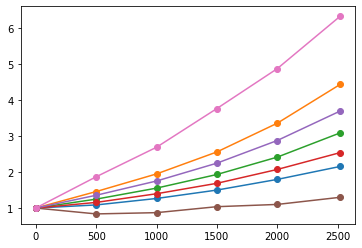

In [12]:
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['10%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['90%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['50%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['25%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['75%'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['min'], marker='o')
plt.plot([0,500,1000,1500,2000,2521],mc_stats.loc['max'], marker='o')
plt.show()

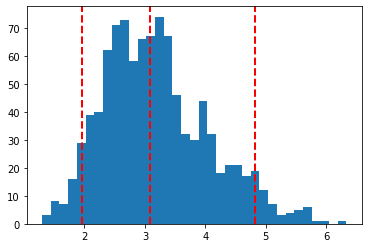

In [13]:
# Statistiche solo sul risultato finale

mc_end_results = mc_runs.iloc[2520]

plt.hist(mc_end_results, bins=35)
plt.axvline(mc_end_results.quantile(0.05), color='r', linestyle='dashed', linewidth=2)
plt.axvline(mc_end_results.quantile(0.5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(mc_end_results.quantile(0.95), color='r', linestyle='dashed', linewidth=2)
plt.show()